# Introduction

In the following, we will estimate a vector autoregressive (VAR) model to predict future returns of the J.P. Morgan Emerging Markets Bond ETF.

The vector autoregressive model is a multivariate time series model that relates current observations of a variable with past observations of itself and past observations of other variables in the system. VAR models differ from univariate autoregressive models because they allow feedback to occur between the variables in the model.

They are widely used in econometrics and are particularly suitable for modeling financial time series as they come with several advantages:

* They are flexible and new information can be easily integrated
* The results are not hidden by a large and complicated structure (“black box”), but are easily interpreted and available
* They have good forecasting capabilities
* It is straightforward to test for Granger causality

We will follow the steps mentioned below in order to build the model:

* Analyze the time series
<br>
* Prepare training and testing data
<br>
* Test for stationarity
<br>
* Differencing the time series
<br>
* Find optimal lag order (p)
<br>
* Fit the model
<br>
* Forecasting

# Import packages

Import packages such as pandas, numpy, matplotlib, scipy, statsmodels and seaborn.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy.stats import pearsonr
from dateutil.relativedelta import relativedelta
import seaborn as sns

# Data importing, cleaning and preprocessing

Monthly closing prices for twelve time series were sourced from Bloomberg for the period January 2008 to January 2022 for a total of 2,028 monthly observations.
<br>

We develop a vector autoregression model and predict logarithmic returns of J.P. Morgan Emerging Markets Bond ETF prices given all the series in our model.
<br>

Logarithmic returns were calculated for the iShares J.P. Morgan USD Emerging Markets Bond ETF time-series and some data cleaning and preprocessing has been done.
<br>

The following provides an overview of the collected data:
<br>

- iShares J.P. Morgan USD Emerging Markets Bond ETF
- DAX Index
- VIX Index
- US 10-year government bond yield
- Euro / U.S. Dollar 
- Bloomberg US Corporate High-Yield Average OAS
- 2-year 10-year yield spread
- Euro Stoxx 50
- S&P 500 Indes
- Gold
- US 10-year breakeven rate
- U.S. Dollar Index

In [2]:
df = pd.read_excel("Data.xlsx", sheet_name="Monthly_Python_Input", index_col=0)

display(df.head())
display(df.tail())
print("shape data:", df.shape) # (168, 12)

,EMB_US_Equity,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
Date,,,,,,,,,,,,
2008-01-31,102.31,6851.75,26.20,3.5931,1.4592,6.68,150.189,3792.80,1378.55,926.10,2.3187,75.178
2008-02-29,101.42,6748.13,26.54,3.5092,1.5179,7.45,189.578,3724.50,1330.63,973.90,2.4398,73.714
2008-03-31,101.09,6534.97,25.61,3.4096,1.5788,7.81,182.115,3628.06,1322.70,916.90,2.3246,71.802
2008-04-30,101.80,6948.82,20.79,3.7279,1.5622,6.53,146.961,3825.02,1385.59,877.55,2.2798,72.509
2008-05-30,101.46,7096.79,17.83,4.0595,1.5554,6.22,145.713,3777.85,1400.38,886.50,2.5250,72.879


,EMB_US_Equity,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
Date,,,,,,,,,,,,
2021-09-30,110.06,15260.69,23.14,1.4873,1.1580,2.89,120.787,4048.08,4307.54,1756.95,2.3762,94.230
2021-10-29,109.89,15688.77,16.26,1.5521,1.1558,2.87,105.118,4250.56,4605.38,1783.38,2.5870,94.123
2021-11-30,107.47,15100.13,27.19,1.4443,1.1338,3.37,87.338,4063.06,4567.00,1774.52,2.5131,95.994
2021-12-31,109.06,15884.86,17.22,1.5101,1.1370,2.83,77.396,4298.41,4766.18,1829.20,2.5947,95.670
2022-01-31,105.38,15471.20,24.83,1.7767,1.1235,3.42,59.603,4174.60,4515.55,1797.17,2.4864,96.540


shape data: (169, 12)


# 1. Analyze the time series

# Descriptive statistics

In [3]:
display(df.describe())

,EMB_US_Equity,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,108.985871,9630.373787,20.408698,2.335886,1.248798,5.462308,141.008343,3121.316331,2110.985740,1353.267692,1.954928,87.824740
std,7.631795,3067.165376,8.975286,0.800412,0.130910,2.605722,77.861499,492.225103,945.023118,281.278919,0.408189,8.594919
min,73.920000,3843.740000,9.510000,0.528200,1.051700,2.680000,-1.391000,1976.230000,735.090000,723.850000,0.088900,71.802000
25%,106.160000,6851.750000,14.030000,1.768700,1.129100,3.710000,79.014000,2768.150000,1325.830000,1184.370000,1.736900,80.035000
50%,110.060000,9805.550000,17.750000,2.333600,1.223800,4.770000,141.401000,3146.430000,1994.990000,1298.510000,2.012200,89.829000
75%,113.680000,12189.040000,24.460000,2.860400,1.348600,6.300000,202.634000,3473.690000,2711.740000,1579.610000,2.243900,95.824000
max,122.790000,15884.860000,59.890000,4.059500,1.578800,18.330000,280.778000,4298.410000,4766.180000,1975.860000,2.594700,102.210000


# Correlation matrix

,EMB_US_Equity,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
EMB_US_Equity,1.000000,0.476283,-0.733160,-0.538141,-0.319609,-0.792482,-0.328113,0.257270,0.359900,0.583098,0.408082,0.212489
Dax_Index,0.476283,1.000000,-0.427488,-0.549495,-0.706637,-0.702787,-0.704641,0.832090,0.949735,0.441084,0.074407,0.754212
VIX_Index,-0.733160,-0.427488,1.000000,0.054495,0.198853,0.779898,0.174683,-0.402264,-0.244495,-0.120313,-0.494470,-0.172696
USGG10YR_Index,-0.538141,-0.549495,0.054495,1.000000,0.621271,0.286794,0.548022,-0.160572,-0.595853,-0.751246,0.215762,-0.536210
EURUSD_BGN_Curncy,-0.319609,-0.706637,0.198853,0.621271,1.000000,0.333705,0.710745,-0.369082,-0.621466,-0.248676,0.381884,-0.968608
LF98OAS_Index,-0.792482,-0.702787,0.779898,0.286794,0.333705,1.000000,0.341159,-0.604119,-0.600980,-0.470949,-0.582540,-0.309241
USYC2Y10_Index,-0.328113,-0.704641,0.174683,0.548022,0.710745,0.341159,1.000000,-0.478971,-0.686647,-0.290067,0.261536,-0.761411
SX5E_Index,0.257270,0.832090,-0.402264,-0.160572,-0.369082,-0.604119,-0.478971,1.000000,0.782389,0.116204,0.219720,0.486324
SPX_Index,0.359900,0.949735,-0.244495,-0.595853,-0.621466,-0.600980,-0.686647,0.782389,1.000000,0.555305,0.086602,0.672003
XAU BGN Curncy,0.583098,0.441084,-0.120313,-0.751246,-0.248676,-0.470949,-0.290067,0.116204,0.555305,1.000000,0.305674,0.134285


<AxesSubplot:>

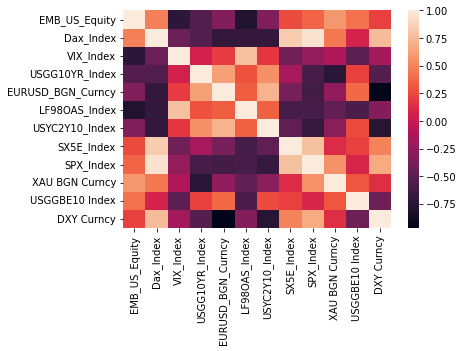

In [4]:
display(df.corr())
display(sns.heatmap(df.corr()))

# Visualization

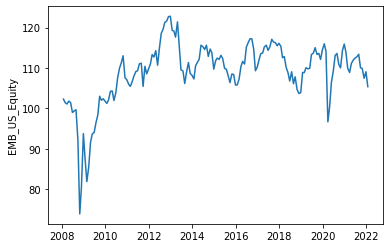

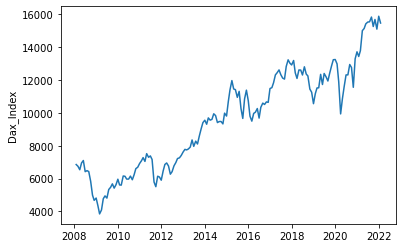

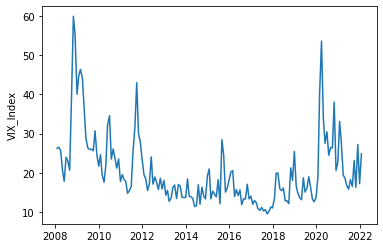

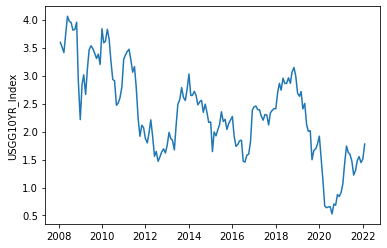

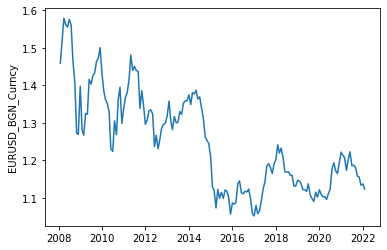

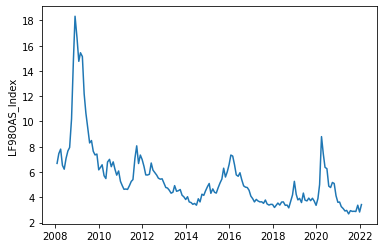

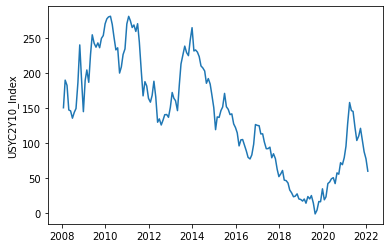

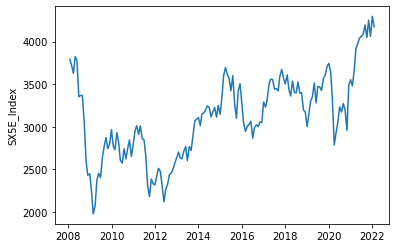

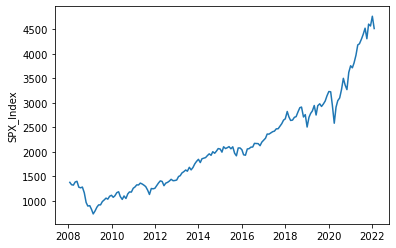

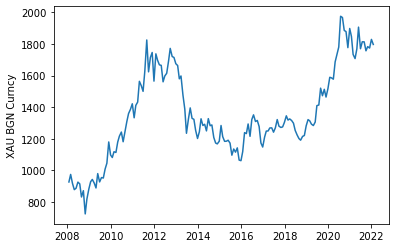

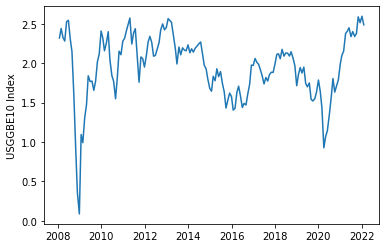

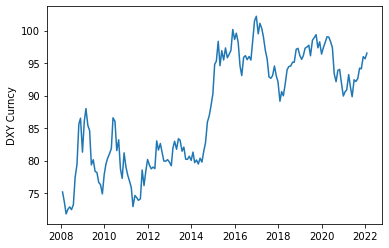

In [5]:
col = df.columns
for x in col:
    plt.plot(df[[x]])
    plt.ylabel(x)
    plt.show()

# 2. Prepare training and testing data

The model forecast is conducted by splitting the data set into an in-sample period, used for the initial parameter estimation and model selection, and an out-of-sample period, used to evaluate forecasting performance.

We split the dataset into training and testing data. 

The model is initially fitted on the training data set.

The fitted model is then used to predict the next four observations into the future (out-of-sample).

In [6]:
# compute log returns for EMB US Equity
df["EMB_US_Equity_log"] = np.log(df.EMB_US_Equity) - np.log(df.EMB_US_Equity.shift(1))
df_viz1 = df # save for later
df = df.drop(columns=["EMB_US_Equity"]).dropna()
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

# split data into training and testing
nobs = 4
df_train, df_test = df[:-nobs], df[-nobs:]

# check size
print(df_train.shape) # (164, 12)
print(df_test.shape) # (4, 12)

(164, 12)
(4, 12)


# 3. Test for stationarity

The Vectorautoregression model requires the time series to be stationary (i.e. mean and variance do not change over time). Therefore, we need to check all the time series in the system for stationarity using unit-root tests. The two most commonly used stationarity tests are the Augmented Dickey-Fuller test (ADF test) and Philip-Perron test.

The Augmented Dickey–Fuller test tests the null hypothesis that a unit root is present in the time series model. If the null hypothesis can be rejected, the time series is stationary.

The output from the code below can be summarized as follows:

Stationary time series:

* EMB US Equity
* VIX Index
* USGGBE10 Index

Non-stationary time series:

* Dax Index
* USGG10YR Index
* EURUSD Index
* LF98OAS Index
* USYC2Y10 Index
* SX5E Index
* SPX Index
* XAU BGN Curncy
* DXY Curncy


In [7]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "EMB_US_Equity_log" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.1746
 No. Lags Chosen       = 0
 Critical value 1%     = -3.471
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Dax_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.3742
 No. Lags Chosen       = 0
 Critical value 1%     = -3.471
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.9143. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "VIX_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit roo

# 4. Differencing the time series

In order to make the non-stationary time series stationary, we take first differences and re-run the Augmented Dickey–Fuller test. The output below summarizes the results, showing that all time series are now stationary and that we can continue with our model.

Stationary time series:

* EMB US Equity
* VIX Index
* USGGBE10 Index
* Dax Index
* USGG10YR Index
* EURUSD Index
* LF98OAS Index
* USYC2Y10 Index
* SX5E Index
* SPX Index
* XAU BGN Curncy
* DXY Curncy

    Augmented Dickey-Fuller Test on "EMB_US_Equity_log" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.8619
 No. Lags Chosen       = 4
 Critical value 1%     = -3.472
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Dax_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.068
 No. Lags Chosen       = 1
 Critical value 1%     = -3.472
 Critical value 5%     = -2.88
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "VIX_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

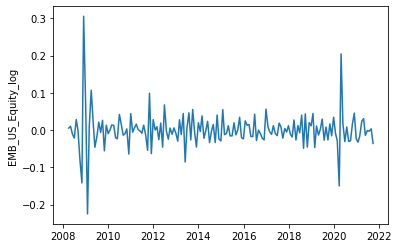

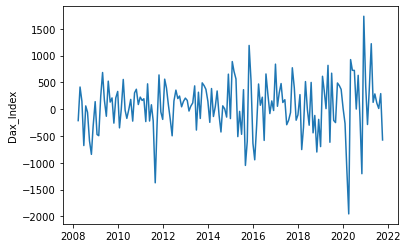

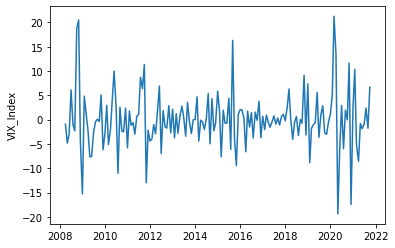

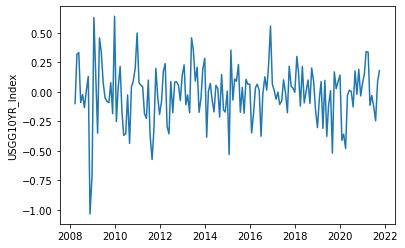

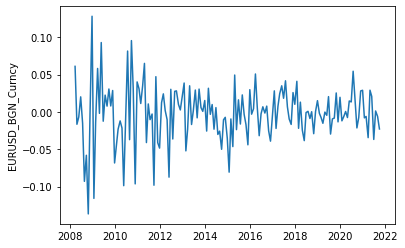

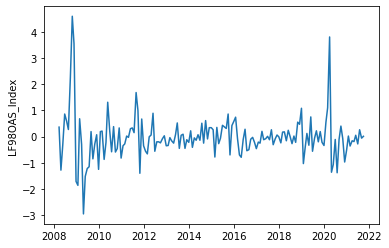

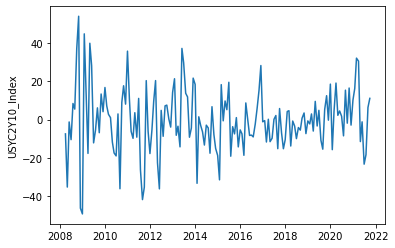

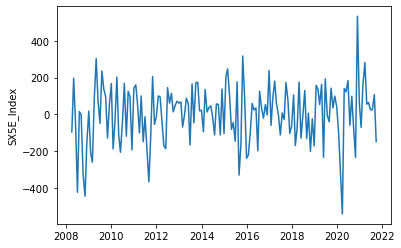

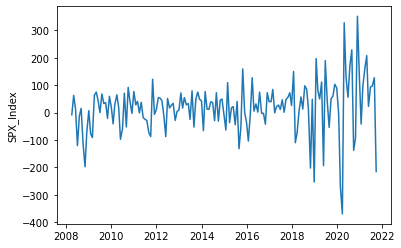

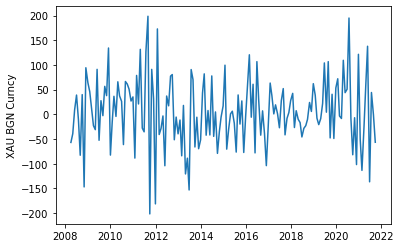

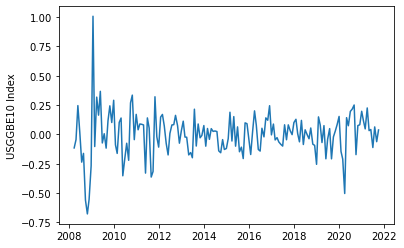

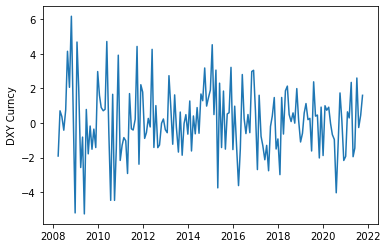

In [8]:
# 1st difference
df_differenced = df_train.diff().dropna()

# # Re-run ADF Test on each column after Differencing
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

# plot data to investigate vizualy
col = df.columns
for x in col:
    plt.plot(df_differenced[[x]])
    plt.ylabel(x)
    plt.show()

# 5. Find optimal lag order (p)

A critical element in the specification of the VAR model is the determination of the lag length, as several studies indicate that overfitting (selecting a higher order lag length than the true lag length) causes an increase in the mean-square-forecast errors of the model and that underfitting the lag length often generates autocorrelated errors (see for example Lütkepohl 1993).

We use symmetric lags, i.e. the same lag length is used for all variables in all equations of the model, and estimate the lag length (p) via lag length selection criteria such as the Akaike’s information criterion (AIC) (Akaike 1973), Bayesian information criterion (BIC) (Schwarz & Gideon (1978), final prediction error (FPE) (Akaike 1969) and Hannan-Quinn criterion (HQC) (Hannan and Quinn 1979). 

AS the results of the lag length criteria are inconsistent, we follow the usual practice of looking at the Akaike’s information criterion (AIC), selecting lag order p = 2 as it provides the lowest value at 19.2347.

In [9]:
model = VAR(df_differenced)
for i in [0,1,2,3,4]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 0
AIC :  20.5645927037248
BIC :  20.79235345470444
FPE :  853276796.9689449
HQIC:  20.657061072426036 

Lag Order = 1
AIC :  19.315736992218877
BIC :  22.28897790762784
FPE :  245765179.22687075
HQIC:  20.52291792872279 

Lag Order = 2
AIC :  19.234738703145283
BIC :  24.976485967091488
FPE :  232670089.74861616
HQIC:  21.566121336133893 

Lag Order = 3
AIC :  19.339003740636265
BIC :  27.872611077910133
FPE :  277473563.798888
HQIC:  22.804206034385523 

Lag Order = 4
AIC :  19.577792724546143
BIC :  30.92694788747379
FPE :  407788361.6576575
HQIC:  24.186563798865382 



C:\Users\t.burggraf\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


# 6. Fit the model

In [10]:
model_fitted = model.fit(2)
display(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 16, Feb, 2022
Time:                     11:14:15
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    24.9765
Nobs:                     161.000    HQIC:                   21.5661
Log likelihood:          -3989.79    FPE:                2.32670e+08
AIC:                      19.2347    Det(Omega_mle):     4.11619e+07
--------------------------------------------------------------------
Results for equation EMB_US_Equity_log
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.002377         0.003345            0.711           0.477
L1.EMB_US_Equity_log        -0.416593         0.135950           -3.064           0.002
L1.Dax_Index        

# 7. Forecasting

One of the most important functions of VAR models is to generate forecasts. Forecasts are generated using the following iterative forecasting algorithm:

* Estimate the VAR model using OLS for each equation.
* Compute the one-period-ahead forecast for all variables.
* Compute the two-period-ahead forecasts, using the one-period-ahead forecast.
* Iterate until the h-step ahead forecasts are computed.

# Backtest October - January 2022

Based on the fitted model, we predict the performance of the J.P. Morgan Emerging Markets Bond index for the next four periods from October 2021 to January 2022.

The actual performance is known, but the prediction is done out-of-sample, i.e. without using information from the future.

2


'Forecast'

,EMB_US_Equity_log_forecast,Dax_Index_forecast,VIX_Index_forecast,USGG10YR_Index_forecast,EURUSD_BGN_Curncy_forecast,LF98OAS_Index_forecast,USYC2Y10_Index_forecast,SX5E_Index_forecast,SPX_Index_forecast,XAU BGN Curncy_forecast,USGGBE10 Index_forecast,DXY Curncy_forecast
Date,,,,,,,,,,,,
2021-10-29,-0.010473,15163.748153,21.394093,1.451182,1.172120,2.868728,126.608558,4004.014755,4314.908418,1792.179931,2.445547,93.639837
2021-11-30,0.004107,15478.866039,16.758491,1.464582,1.171364,2.600413,126.097693,4076.877955,4388.718451,1800.718470,2.436235,93.723955
2021-12-31,-0.003675,15642.063460,16.671775,1.505909,1.162496,2.215692,126.503602,4107.532008,4416.414358,1792.513192,2.499940,93.977280
2022-01-31,-0.012723,15667.572056,17.583973,1.510377,1.160854,2.214035,128.125228,4102.965707,4430.219210,1805.737611,2.514180,94.043150


'Actual'

,EMB_US_Equity_log,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
Date,,,,,,,,,,,,
2021-10-29,-0.001546,15688.77,16.26,1.5521,1.1558,2.87,105.118,4250.56,4605.38,1783.38,2.5870,94.123
2021-11-30,-0.022268,15100.13,27.19,1.4443,1.1338,3.37,87.338,4063.06,4567.00,1774.52,2.5131,95.994
2021-12-31,0.014686,15884.86,17.22,1.5101,1.1370,2.83,77.396,4298.41,4766.18,1829.20,2.5947,95.670
2022-01-31,-0.034325,15471.20,24.83,1.7767,1.1235,3.42,59.603,4174.60,4515.55,1797.17,2.4864,96.540


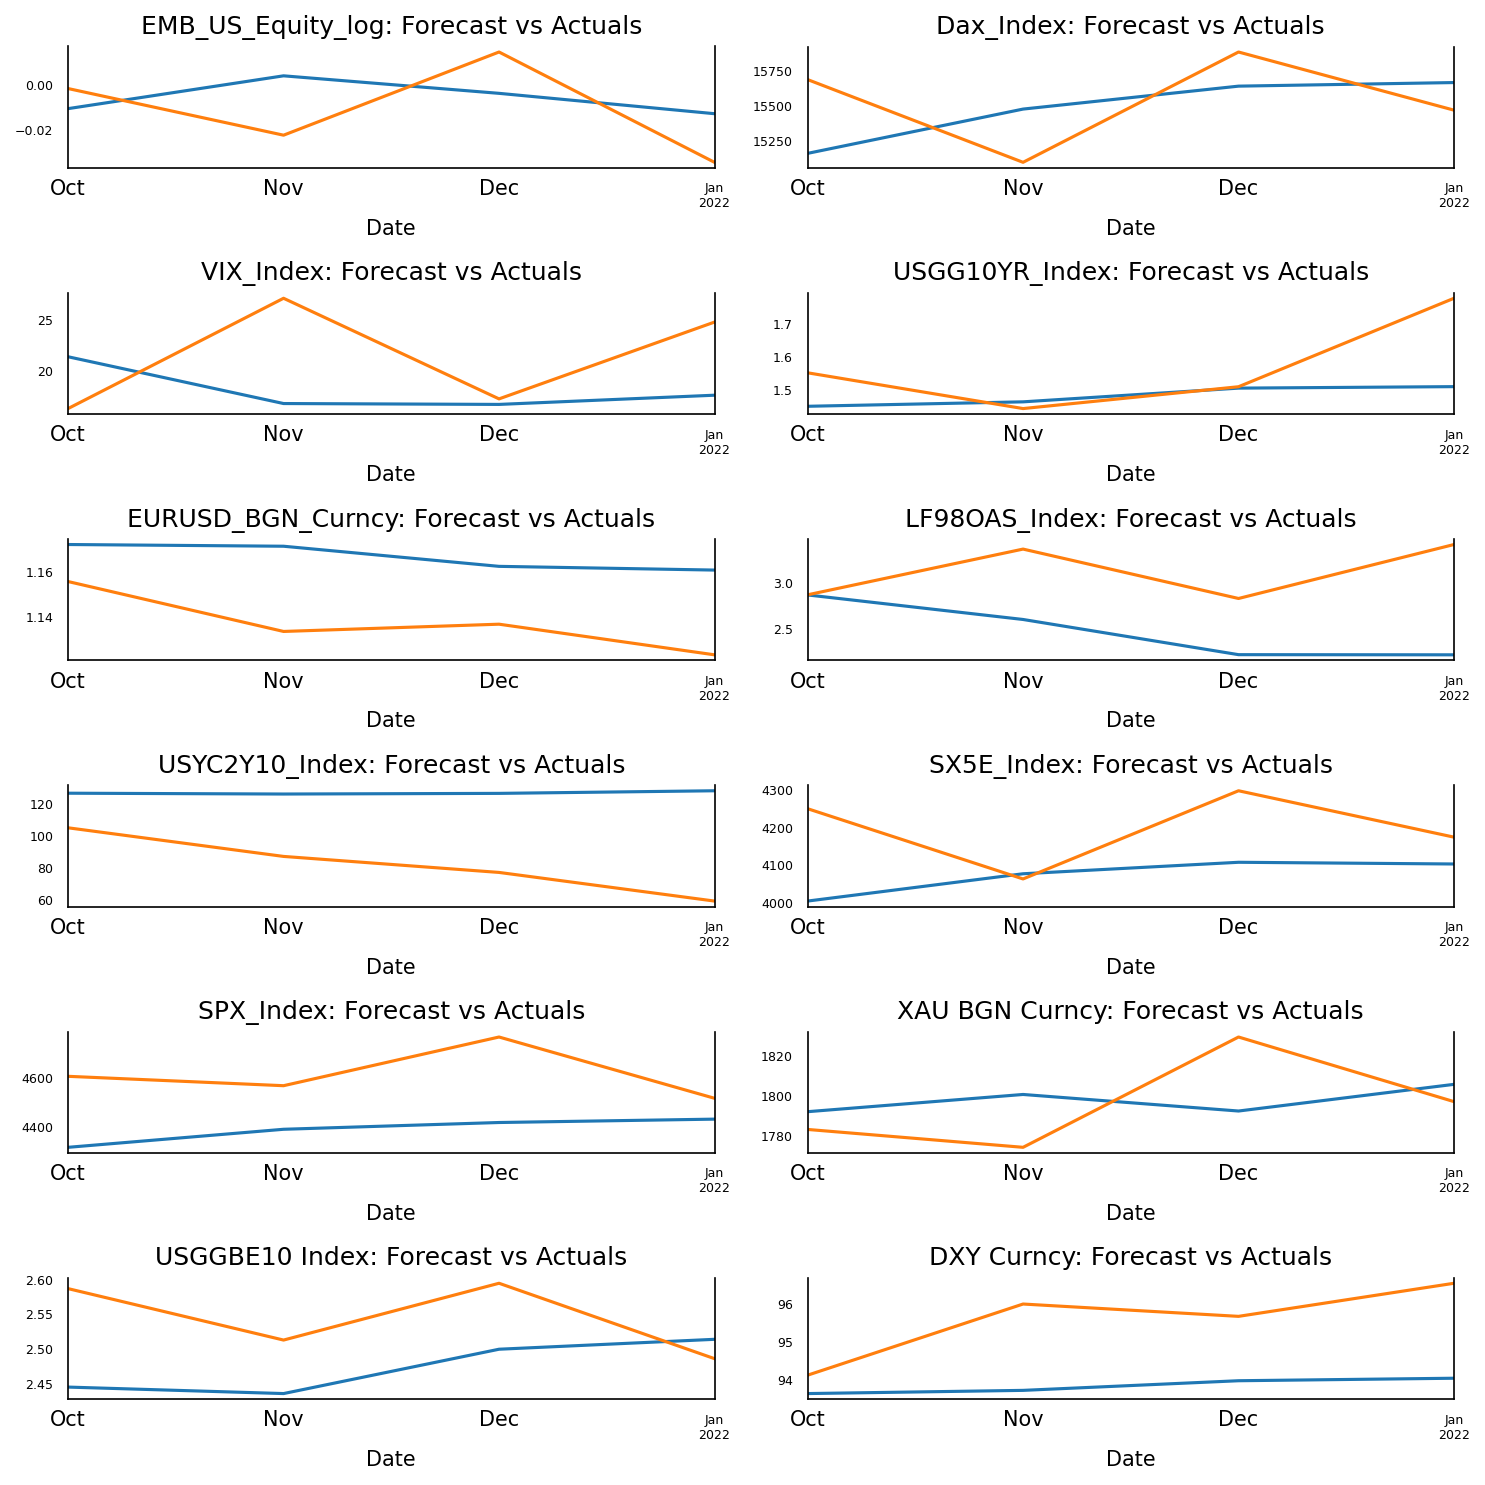

In [11]:
# Forecast with the VAR model
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 2

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]

fc = model_fitted.forecast(y=forecast_input, steps=nobs) # hier auch 7 steps eingeben!
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')

# Reverse differencing
def invert_transformation(df_train, df_forecast, second_diff=False):
    """The forecasts are generated, but on the scale of the training data. 
    Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_train, df_forecast, second_diff=False)

df_results = df_results.loc[:, ['EMB_US_Equity_log_forecast', 'Dax_Index_forecast', 'VIX_Index_forecast', 'USGG10YR_Index_forecast',
                   'EURUSD_BGN_Curncy_forecast', 'LF98OAS_Index_forecast', 'USYC2Y10_Index_forecast', 'SX5E_Index_forecast',
                   'SPX_Index_forecast', 'XAU BGN Curncy_forecast', 'USGGBE10 Index_forecast', 'DXY Curncy_forecast']]

display("Forecast", df_results)
display("Actual", df[-4:])

# Plot of forecasts vs actuals
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=False, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=False, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
plt.show()

# Forecast February - May 2022

Lastly, we fit the model on the entire data set to make predictions about the future performance of the J.P. Morgan Emerging Market Bond Index in the months from February 2022 to May 2022.

The J.P. Morgan Emerging Market Bond Index closed on 31.01.2022 at 105.38 and is currently trading at 103.14 (15.02.2022). 

The model predicts the J.P. Morgan Emerging Market Bond Index to close at 106.07 on 28.05.2022.

This translates into a 2.8% upside over the next three months (11.4% annualized)

-> Buy signal

In [16]:
df_differenced = df.diff().dropna()
model = VAR(df_differenced)

# Train the VAR model
lag_order = 2
model_fitted = model.fit(lag_order)

# forecasting
forecast_input = df_differenced.values[-lag_order:]

ind = df.index
ind = ind.tolist()

list = [1,2,3,4]
for x in list:
    future_date = ind[-1] + relativedelta(months=1)
    ind.append(future_date)

fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc,index=ind[-nobs:], columns=df.columns + '_1d')

# Reverse invert
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_train, df_forecast, second_diff=False)

df_results = df_results.loc[:, ['EMB_US_Equity_log_forecast', 'Dax_Index_forecast', 'VIX_Index_forecast', 'USGG10YR_Index_forecast',
                   'EURUSD_BGN_Curncy_forecast', 'LF98OAS_Index_forecast', 'USYC2Y10_Index_forecast', 'SX5E_Index_forecast',
                   'SPX_Index_forecast', 'XAU BGN Curncy_forecast', 'USGGBE10 Index_forecast', 'DXY Curncy_forecast']]

#display("Forecast",df_results)

C:\Users\t.burggraf\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,EMB_US_Equity_ee
2022-01-31,105.380000
2022-02-28,106.456883
2022-03-28,107.412122
2022-04-28,106.186923
2022-05-28,106.065948


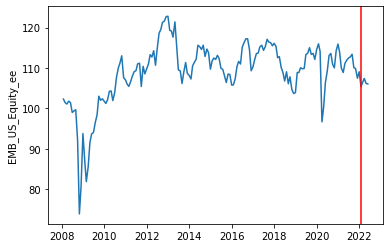

In [15]:
# visualize results
df_price = df_viz1[-4:]
df_price = df_price[["EMB_US_Equity"]]

df_log = df_results[["EMB_US_Equity_log_forecast"]]

df2 = pd.concat([df_price, df_log])
df2["EMB_US_Equity_log_forecast"] = df2["EMB_US_Equity_log_forecast"]+1
df2["EMB_US_Equity_e"] = df2["EMB_US_Equity"].fillna(0)+df2["EMB_US_Equity_log_forecast"].fillna(0)
df2 = df2[["EMB_US_Equity_e"]]
df2 = df2[-5:].cumprod()

df3 = df_viz1[["EMB_US_Equity"]]
df_con = pd.concat([df3, df2[1:]])
df_con["EMB_US_Equity_ee"] = df_con["EMB_US_Equity_e"].fillna(0)+df_con["EMB_US_Equity"].fillna(0)
df_con = df_con[["EMB_US_Equity_ee"]]

display(df_con[-5:])

plt.plot(df_con[["EMB_US_Equity_ee"]])
plt.ylabel("EMB_US_Equity_ee")
plt.axvline(pd.Timestamp('2022-01-31'),color='r')
plt.show()